# Prepare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install NeuralProphet

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime
from neuralprophet import NeuralProphet

In [ ]:
# 데이터 불러오기
PATH = '/content/drive/MyDrive/DACON/'
train = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test = pd.read_csv(PATH+'test.csv')
sub = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
train

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [ ]:
# 시간 변환 함수1: 1 -> 01:00:00 
def convert_time1(x):
    if x<10:
      return '0'+str(x)+':00:00'
    else:
      return str(x)+':00:00'

# 시간 변환 함수2: 1~24 -> 0~23 
def convert_time2(HMS):
    #Ymd, HMS = x.split(' ')
    H, M, S = HMS.split(':')
    H = str(int(H)-1)
    HMS = ':'.join([H, M, S])
    return HMS

# 시간 변환
train['시간'] = train['시간'].apply(lambda x:convert_time1(x))
train['시간'] = train['시간'].apply(lambda x:convert_time2(x))

In [ ]:
# time 변수 생성
train['time'] = train['연월일'] + " " + train['시간']
train['time'] = pd.to_datetime(train['time'])

# 구분별 데이터 생성
구분 = list(train['구분'].unique())
for i in 구분:
  globals()['train_{}'.format(i)] = train[train['구분']==i]  

# 훈련 데이터 만들기
for i in 구분:
  globals()['df_{}'.format(i)] = pd.DataFrame()
  locals()['df_{}'.format(i)]['ds'] = locals()['train_{}'.format(i)]['time']
  locals()['df_{}'.format(i)]['y'] = locals()['train_{}'.format(i)]['공급량']

In [ ]:
df_A

,ds,y
0,2013-01-01 00:00:00,2497.129
1,2013-01-01 01:00:00,2363.265
2,2013-01-01 02:00:00,2258.505
3,2013-01-01 03:00:00,2243.969
4,2013-01-01 04:00:00,2344.105
...,...,...
315523,2018-12-31 19:00:00,3040.868
315524,2018-12-31 20:00:00,2973.577
315525,2018-12-31 21:00:00,2840.272
315526,2018-12-31 22:00:00,2692.385


* prophet의 변수 형태: ds(시계열) & y(타겟)
* ds: 연월일 + 시간
* y: 공급량

# Predict

In [ ]:
# 학습 및 예측 함수
def train_predict(df):
  model = NeuralProphet()
  model.fit(df,                       # 데이터 셋
            freq='H',                 # 시간별 예측
            validate_each_epoch=True, # 각 시기 유효성 검사 데이터에 대한 모델 성능 검증 여부
            valid_p=0.2,              # 유효성 검사에 사용하는 데이터 비율
            plot_live_loss=True,      # 모델의 훈련 및 검증 손실에 대한 live plot 생성 여부
            epochs=20                 # 모델 훈련 수
            ) 
  df_pred = model.make_future_dataframe(df, periods=24*(31+28+31)) # 예측을 담을 데이터프레임 생성
  predict = model.predict(df_pred)                                 # 예측 
  predict_plot = model.plot(predict)                               # 예측 plot
  return predict, predict_plot

WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 1.02E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.74E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it, SmoothL1Loss=0.00439, MAE=167, MSE=5.35e+4, RegLoss=0, MAE_val=211, MSE_val=8.33e+4, SmoothL1Loss_val=0.00703]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.44E-02, min: 1.40E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.07E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it, SmoothL1Loss=0.00457, MAE=152, MSE=4.19e+4, RegLoss=0, MAE_val=197, MSE_val=7.99e+4, SmoothL1Loss_val=0.00872]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.68E-02, min: 1.31E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.61E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it, SmoothL1Loss=0.00797, MAE=19.8, MSE=817, RegLoss=0, MAE_val=25.5, MSE_val=1.31e+3, SmoothL1Loss_val=0.0128]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.42E-02, min: 1.58E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.81E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:41<00:00,  2.06s/it, SmoothL1Loss=0.00382, MAE=94.8, MSE=1.6e+4, RegLoss=0, MAE_val=119, MSE_val=2.78e+4, SmoothL1Loss_val=0.00665]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.85E-02, min: 1.02E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.10E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it, SmoothL1Loss=0.00404, MAE=204, MSE=7.5e+4, RegLoss=0, MAE_val=283, MSE_val=1.58e+5, SmoothL1Loss_val=0.00854]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.51E-02, min: 1.23E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.37E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it, SmoothL1Loss=0.00426, MAE=241, MSE=1.11e+5, RegLoss=0, MAE_val=342, MSE_val=2.39e+5, SmoothL1Loss_val=0.00927]
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64


  0%|          | 0/331 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.44E-02, min: 1.23E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.74E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it, SmoothL1Loss=0.00461, MAE=38, MSE=4.55e+3, RegLoss=0, MAE_val=45.8, MSE_val=4.18e+3, SmoothL1Loss_val=0.0065]


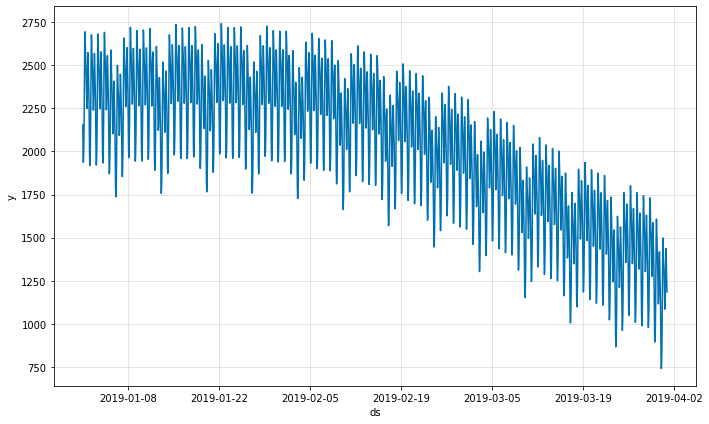

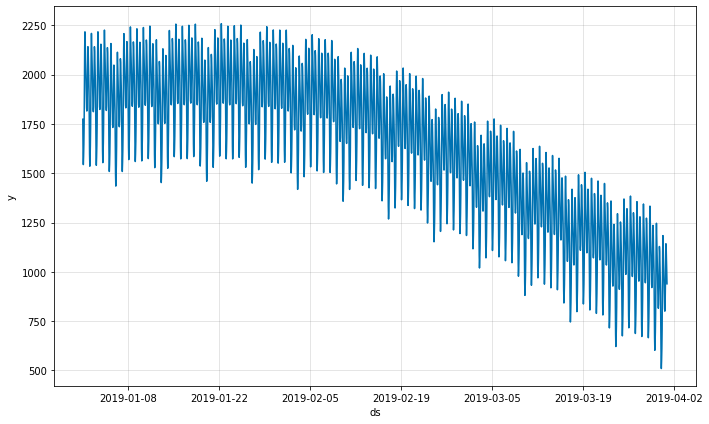

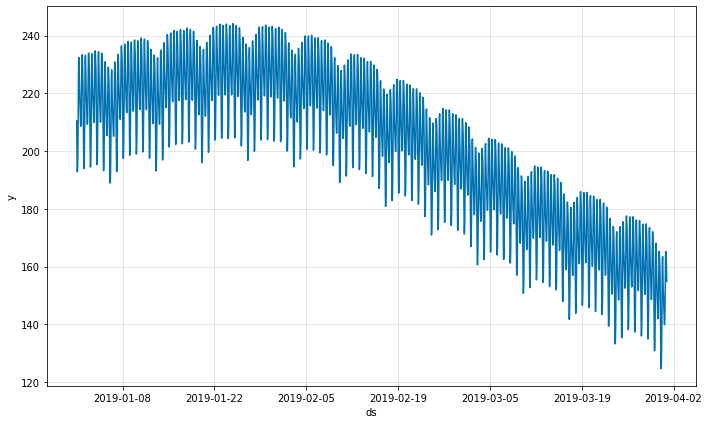

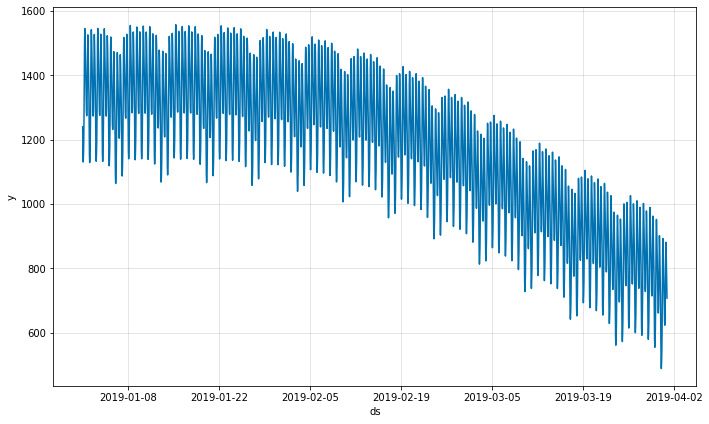

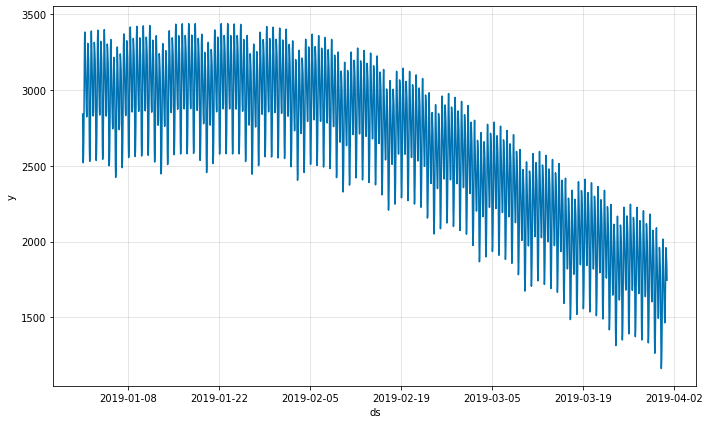

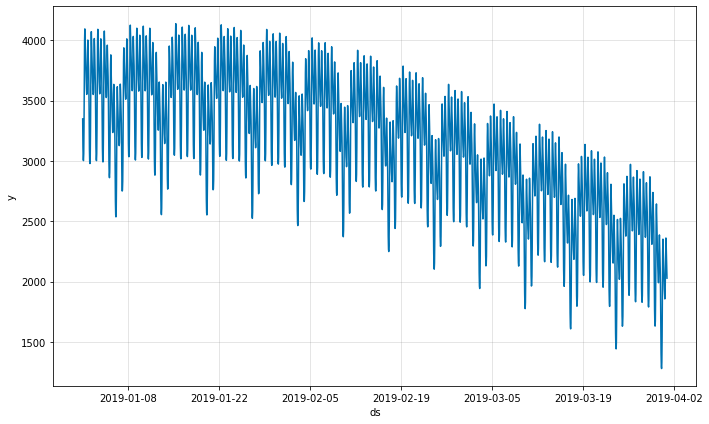

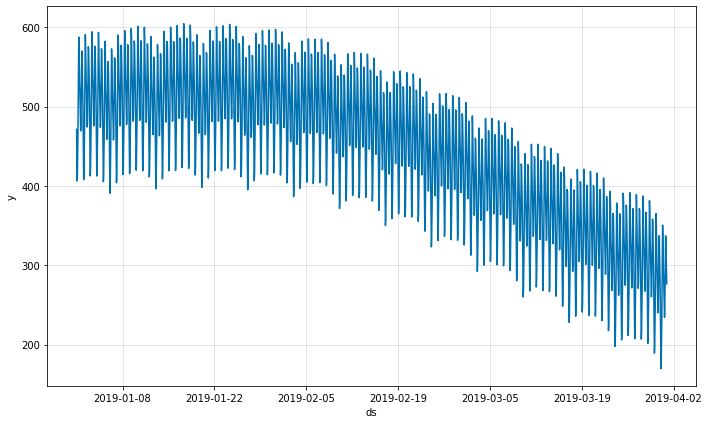

In [ ]:
# 구분별 학습
for i in 구분:
  globals()['predict_{}'.format(i)] = train_predict(locals()['df_{}'.format(i)])

# Trend
* Trend: 추세 성분 모델링


# Seasonality
* Seasonality: 계절 성분 모델링

# AR-Net
* AR-Net: 자기 회귀 신경 네트워크. 이전 시간 단계의 과거 데이터를 사용하여 다음 시간 단계에 대한 예측 생성 

# Recurring Events
* Recurring Events: (미국) 공휴일 날짜를 고려하도록 모델 구성 
* 아쉽게도 옵션에 한국은 없음 -> github 참고해서 커스텀 이벤트 생성 

# Submit

In [ ]:
# 제출 준비
preds = []
for i, j in enumerate(구분):
  # 무서우니 일단 복제
  globals()['predict_{}'.format(i+1)] = locals()['predict_{}'.format(j)][0].copy()
  # 구분별 공급량 예측 추출
  locals()['predict_{}'.format(i+1)] = locals()['predict_{}'.format(i+1)]['yhat1']
  # 전체 공급량 예측 병합
  preds.append(locals()['predict_{}'.format(i+1)])

# 제출 업데이트
predict = pd.DataFrame(pd.concat(preds, axis=0)).reset_index()
sub['공급량'] = predict['yhat1']
sub

,일자|시간|구분,공급량
0,2019-01-01 01 A,2152.506592
1,2019-01-01 02 A,1999.305908
2,2019-01-01 03 A,1936.623779
3,2019-01-01 04 A,1964.818237
4,2019-01-01 05 A,2037.715454
...,...,...
15115,2019-03-31 20 H,337.167542
15116,2019-03-31 21 H,334.938141
15117,2019-03-31 22 H,314.433411
15118,2019-03-31 23 H,295.600616


In [ ]:
sub.to_csv('jk_1109_prophet.csv', index=False)

# Reference
* ARIMA vs LSTM vs __PROPHET__
  * https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b
  * __https://zzsza.github.io/data/2019/02/06/prophet/__
* fbprophet: 기본 prophet 라이브러리
  * https://study2give.tistory.com/entry/Python-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%8D%B8%EC%9D%84-%ED%86%B5%ED%95%9C-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0
  * https://dacon.io/competitions/official/235720/codeshare/2809?page=1&
  * https://today-1.tistory.com/41?category=897491

* neuralprophet: fbprophet 업그레이드 버전 
  * https://dacon.io/competitions/official/235720/codeshare/2492?page=1&dtype=vote
  * __http://insightcampus.co.kr:9090/insightcommunity/?mod=document&uid=12964__


In [ ]:
#YMD 전처리
df['datetime'] = pd.to_datetime(df['YMD'].apply(lambda x: x.split()[0]))
df['time'] = df['YMD'].apply(lambda x: x.split()[1])
df['date'].apply(lambda x: x.split()[1])
df['month'] = df['date'].dt.month